# H2O Automated Machine Learning (AutoML)

## 0 Introduction
The objective of this notbook is to use to data generated from the previous notebooks to carry out Automated Machine Learning (AutoML) and captrure the important features at the underlying structure of signal peptides. In order to achieve this, the predictions of SignalP algorithm will be merged with the observations of Proteomics results obtained from the previous two notebooks, respectively. This will enable the observed signal peptides to be assigned with peptide abundance, while keeping the predicted signal peptides at zero abundance, thus generating a dataframe that emphasizes importance of signal peptides through the peptide abundance. 

### Agenda
- Generate dataframe for AutoML
- Utilize AutoML to carry out ML operations
- Determine the best AutoML model generated
- Analyze the best model parameters 
- Check AutoML prediction based on the best model

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [9]:
def one_hot_encode_aa(df):
    """One-hot encode amino acid sequences in a pandas dataframe"""

    # Define amino acid alphabet
    aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                   'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']

    # Determine maximum sequence length in input dataframe
    max_seq_len = df.applymap(len).max().max()

    # Initialize one-hot encoding dataframe
    encoding_df = pd.DataFrame()

    # Loop over columns in input dataframe and encode each amino acid sequence
    for col in df.columns:
        # Extract amino acid sequences from current column
        seqs = df[col].values

        # Initialize 2D array to hold one-hot encoding for current column
        encoding_matrix = np.zeros((len(seqs), max_seq_len * len(aa_alphabet)))

        # Loop over amino acid sequences and one-hot encode each one
        for i, seq in enumerate(seqs):
            # Get one-hot encoding vector for current amino acid sequence
            encoding_vec = np.zeros((max_seq_len, len(aa_alphabet)))
            for j, aa in enumerate(seq):
                encoding_vec[j, aa_alphabet.index(aa)] = 1

            # Flatten encoding vector and add it to encoding matrix for current column
            encoding_matrix[i, :] = encoding_vec.flatten()

        # Convert encoding matrix to dataframe and add it to one-hot encoding dataframe
        col_encoding_df = pd.DataFrame(encoding_matrix)
        col_encoding_df.columns = [f'{col}_{j}' for j in range(max_seq_len * len(aa_alphabet))]
        encoding_df = pd.concat([encoding_df, col_encoding_df], axis=1)

    return encoding_df


def one_hot_decode_aa(df, max_length = 22):
    # Define amino acid alphabet
    aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                    'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    sps = []
    peptide = ''
    cols = list(df.columns)

    for index, row in df.iterrows():
        for col in cols: 
            if int(row[col]) ==1: 
                aa_index = int(col.split('_')[1])
                aa_acid = aa_alphabet[aa_index]
                peptide += aa_acid
                if len(peptide) == max_length: 
                    sps.append(peptide)
                    peptide = ''

    df['decoded_sequence'] = sps

    return df

## 1 ML dataframe generation

In [10]:
# Load the mean proteomcis dataset and common signal peptide dataset obtained from previous notebooks
#df_proteomcis_abundance_means = pd.read_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/proteomics_mean_peptide_abundances.csv')
df_proteomcis_abundance_means = pd.read_csv('../data/03_proteomics_data/proteomics_mean_peptide_abundances.csv')
df_signalP_predictions = pd.read_excel('../data/02_all_signal_peptides/sigpep_predict.xlsx')

In [11]:
df_proteomcis_abundance_means

,Accession,MM mean abundances (Scaled),MM mean abundances (Scaled-Normalized),MM + Nitrogen mean abundances (Scaled),MM + Nitrogen mean abundances (Scaled-Normalized),MM mean abundances (Raw),MM mean abundances (Raw-Normalized),MM + Nitrogen mean abundances (Raw),MM + Nitrogen mean abundances (Raw-Normalized)
0,AO090003000935-T-p1,5.700000,0.059285,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923
1,AO090023000944-T-p1,250.433333,0.044270,53.733333,0.044270,2.632887e+08,0.025062,7.327970e+07,0.017628
2,AO090003001591-T-p1,230.066667,0.058537,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000
3,AO090005001300-T-p1,50.566667,0.080759,94.433333,0.080759,3.997800e+07,0.003882,9.707511e+07,0.024045
4,AO090010000746-T-p1,105.633333,0.228295,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331
...,...,...,...,...,...,...,...,...,...
860,AO090001000075-T-p1,110.200000,0.254802,310.600000,0.254802,1.013201e+05,0.000010,3.909362e+05,0.000090
861,AO090005001355-T-p1,105.400000,0.122683,184.200000,0.122683,3.984604e+04,0.000003,9.575187e+04,0.000015
862,AO090003000247-T-p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
863,AO090001000680-T-p1,NaN,0.309596,389.333333,0.309596,NaN,NaN,9.818556e+04,0.000019


In [12]:
df_signalP_predictions

,Unnamed: 0,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,0,AO090005000016-T-p1,0,25,0.999803,MAPSHSFMLFLSVICTHLCSLVVAV
1,3,AO090005000029-T-p1,0,25,0.999835,MHLRNIVIALAATAVASPVDLQDRQ
2,6,AO090005000042-T-p1,0,25,0.999843,MKASFISRLLSLTAFAISSNLSYGL
3,9,AO090005000053-T-p1,0,43,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ
4,12,AO090005000059-T-p1,0,20,0.999821,MHLQATLAVGLSLLGLTLAD
...,...,...,...,...,...,...
1056,3168,AO090103000483-T-p1,0,21,0.833106,MKTSFLLAAIGFLYRLPCSAA
1057,3171,AO090103000487-T-p1,0,21,0.999710,MTRYLSFLFLLILFGNSVFTA
1058,3174,AO090103000493-T-p1,0,19,0.999791,MRGIVALSFLSVALGVTAD
1059,3177,AO090701000994-T-p1,0,20,0.999845,MRLLLIAPLFSAVSYGAQAT


In [13]:
# Change the name to allow merge
df_signalP_predictions = df_signalP_predictions.rename(columns={'gene': 'Accession', 'end_pos': 'length'})

In [14]:
df_signalP_predictions

,Unnamed: 0,Accession,start_pos,length,signal_peptide_likelyhood,sequence
0,0,AO090005000016-T-p1,0,25,0.999803,MAPSHSFMLFLSVICTHLCSLVVAV
1,3,AO090005000029-T-p1,0,25,0.999835,MHLRNIVIALAATAVASPVDLQDRQ
2,6,AO090005000042-T-p1,0,25,0.999843,MKASFISRLLSLTAFAISSNLSYGL
3,9,AO090005000053-T-p1,0,43,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ
4,12,AO090005000059-T-p1,0,20,0.999821,MHLQATLAVGLSLLGLTLAD
...,...,...,...,...,...,...
1056,3168,AO090103000483-T-p1,0,21,0.833106,MKTSFLLAAIGFLYRLPCSAA
1057,3171,AO090103000487-T-p1,0,21,0.999710,MTRYLSFLFLLILFGNSVFTA
1058,3174,AO090103000493-T-p1,0,19,0.999791,MRGIVALSFLSVALGVTAD
1059,3177,AO090701000994-T-p1,0,20,0.999845,MRLLLIAPLFSAVSYGAQAT


In [15]:
# Merge the dataframes
df_ML_signal_peptides = pd.merge(df_proteomcis_abundance_means, df_signalP_predictions, on='Accession', how='right')

# Set NaN values to zero
df_ML_signal_peptides.fillna(value=0, inplace=True)

# Create a new column that sorts the accession in a descending order to abundances observed in the raw data column
df_ML_signal_peptides['max_abundance'] = df_ML_signal_peptides[['MM mean abundances (Raw)', 'MM + Nitrogen mean abundances (Raw)']].max(axis=1)
df_ML_signal_peptides = df_ML_signal_peptides.sort_values(by='max_abundance', ascending=False)

df_ML_signal_peptides

,Accession,MM mean abundances (Scaled),MM mean abundances (Scaled-Normalized),MM + Nitrogen mean abundances (Scaled),MM + Nitrogen mean abundances (Scaled-Normalized),MM mean abundances (Raw),MM mean abundances (Raw-Normalized),MM + Nitrogen mean abundances (Raw),MM + Nitrogen mean abundances (Raw-Normalized),Unnamed: 0,start_pos,length,signal_peptide_likelyhood,sequence,max_abundance
318,AO090003001591-T-p1,230.066667,0.058537,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000,954,0,22,0.999866,MMVAWWSLFLYGLQVAAPALAA,1.047763e+10
269,AO090003000935-T-p1,5.700000,0.059285,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923,807,0,29,0.999834,MEAFNLHNFLSSLYILLPFVILANPVHAA,1.494872e+09
1020,AO090103000076-T-p1,0.700000,0.430035,472.900000,0.430035,1.496427e+06,0.000144,1.202415e+09,0.339312,3060,0,20,0.999835,MLRVSAIFMACLLLATAAPT,1.202415e+09
401,AO090026000003-T-p1,0.833333,0.414383,470.100000,0.414383,1.498718e+06,0.000144,1.061096e+09,0.276919,1203,0,26,0.848574,MAVRIARFLGLSTVAYLALANGIDAR,1.061096e+09
1011,AO090010000746-T-p1,105.633333,0.228295,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331,3033,0,26,0.999747,MVSFSSCLRALALGSSVLAVQPVLRQ,8.634503e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,AO090026000252-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1266,0,20,0.999834,MQVKLFYTLALWAPILVSAQ,0.000000e+00
423,AO090026000257-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1269,0,17,0.999809,MKSLIWALPFIPLAYAN,0.000000e+00
425,AO090026000367-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1275,0,24,0.999847,MWPTRSLSSLFFLSLALGSPVSQT,0.000000e+00
427,AO090026000428-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1281,0,24,0.999792,MLLPRLSSLLCLAGLATMPVANAY,0.000000e+00


In [16]:
# Change the name for simplicity
df_ML_signal_peptides  = df_ML_signal_peptides.rename(columns={'MM + Nitrogen mean abundances (Raw-Normalized)': 'abundance',})

# Isolate the desired columns from the dataframe
df_ML_signal_peptides = df_ML_signal_peptides[['Accession','sequence', 'length', 'abundance']]
df_ML_signal_peptides

,Accession,sequence,length,abundance
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331
...,...,...,...,...
422,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000
423,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,0.000000
425,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,0.000000
427,AO090026000428-T-p1,MLLPRLSSLLCLAGLATMPVANAY,24,0.000000


In [17]:
# binary classification of signal_peptides
df_ML_signal_peptides['binary_classification'] = (df_ML_signal_peptides['abundance'] > 0).astype(int)
df_ML_signal_peptides


,Accession,sequence,length,abundance,binary_classification
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
422,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000,0
423,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,0.000000,0
425,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,0.000000,0
427,AO090026000428-T-p1,MLLPRLSSLLCLAGLATMPVANAY,24,0.000000,0


In [18]:
#random_signal_peptides_predicted_bySignalP = pd.read_csv('../data/05_best_signal_peptides/random_peptides_for_ML_training/prediction_results.txt')
#random_signal_peptides_predicted_bySignalP

In [19]:
# Convert and save a summary dataframe
ml_save = True # change this to save the dataframe
if ml_save:
  df_ML_signal_peptides.to_csv('../data/03_proteomics_data/ML_signal_peptides.csv', index=False)

## 2 Data preparation for H2O AutoML

In [20]:
# Load the dataframe generated in the previous notebook for AutoML operations
df_signalPP = pd.read_csv('../data/03_proteomics_data/ML_signal_peptides.csv')
df_signalPP

,Accession,sequence,length,abundance,binary_classification
0,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
1,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
2,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
3,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
4,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
1056,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000,0
1057,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,0.000000,0
1058,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,0.000000,0
1059,AO090026000428-T-p1,MLLPRLSSLLCLAGLATMPVANAY,24,0.000000,0


In [21]:
# Select only rows where "length" column is 22 or smaller
df_signalPP_filtered = df_signalPP[df_signalPP["length"] <= 22]
df_signalPP_filtered = df_signalPP_filtered.reset_index()
df_signalPP_filtered

,index,Accession,sequence,length,abundance,binary_classification
0,0,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
1,2,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
2,7,AO090023000944-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,0.017628,1
3,8,AO090701000295-T-p1,MHLPTLVTLACMAVSASAF,19,0.071338,1
4,9,AO090012000708-T-p1,MKISAAISTALLAVSAAAF,19,0.060200,1
...,...,...,...,...,...,...
587,1053,AO090026000214-T-p1,MQLKNAIHFTVFGCAILALAH,21,0.000000,0
588,1054,AO090026000220-T-p1,MARIHLYSWMTLFAGTFAQ,19,0.000000,0
589,1055,AO090026000221-T-p1,MAQLQYLFAFILVQLQLAGAQ,21,0.000000,0
590,1056,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000,0


In [22]:
describe = df_signalPP_filtered["sequence"].describe()
describe 


count                        592
unique                       590
top       MMVAWWSLFLYGLQVAAPALAA
freq                           3
Name: sequence, dtype: object

In [23]:
describe = df_signalPP_filtered["length"].describe()
describe

count    592.000000
mean      19.685811
std        1.650289
min       14.000000
25%       19.000000
50%       20.000000
75%       21.000000
max       22.000000
Name: length, dtype: float64

In [24]:
describe = df_signalPP_filtered["abundance"].describe()
describe

count    592.000000
mean       0.003084
std        0.043585
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: abundance, dtype: float64

In [25]:
### Adding random signal peptides to training data 
random_signal_peptides = pd.read_csv('../data/05_best_signal_peptides/random_peptides_for_ML_training/no_sp_predicted_by_signalP_22.csv', index_col=False)
random_signal_peptides = random_signal_peptides[['name', 'sequence', 'abundance']]
random_signal_peptides


,name,sequence,abundance
0,sp_random_1,MTQFQKHMNFDKPFNGARRKPM,0.0
1,sp_random_2,MAISSMVYGQAKHISFLYFMSK,0.0
2,sp_random_3,MHALWCGKFHNVEECMSKGEEL,0.0
3,sp_random_4,MTDIAKQRNEIHNLSATMSKGE,0.0
4,sp_random_5,MFFGKQDQVEYPYHIAGVRRPL,0.0
...,...,...,...
4847,sp_random_4996,MDNNFYQGHTKSDFKMRWLNMS,0.0
4848,sp_random_4997,MTVEQLNNCCGIPSKQMSKGEE,0.0
4849,sp_random_4998,MHAMELQGEEPEAHLCGRIYFM,0.0
4850,sp_random_4999,MFGYNAQSPYENRVTQFMSKGE,0.0


In [26]:
#concat dataframes 
result = pd.concat([df_signalPP_filtered,random_signal_peptides ])
result = result[['sequence', 'abundance']]
result


,sequence,abundance
0,MMVAWWSLFLYGLQVAAPALAA,1.000000
1,MLRVSAIFMACLLLATAAPT,0.339312
2,MMVAWWSLFLYGLQVAAPALAA,0.017628
3,MHLPTLVTLACMAVSASAF,0.071338
4,MKISAAISTALLAVSAAAF,0.060200
...,...,...
4847,MDNNFYQGHTKSDFKMRWLNMS,0.000000
4848,MTVEQLNNCCGIPSKQMSKGEE,0.000000
4849,MHAMELQGEEPEAHLCGRIYFM,0.000000
4850,MFGYNAQSPYENRVTQFMSKGE,0.000000


### Make it BINARY - DEEPLOC predictions

In [46]:
deep_loc_predictions1 = pd.read_csv('../data/03_proteomics_data/deeploc_predictions/all_sps/results_646764CA00004786815A8068.csv')
deep_loc_predictions2 = pd.read_csv('../data/03_proteomics_data/deeploc_predictions/all_sps/results_6467637F0000328EBD10D7B6.csv')
deep_loc_predictions3 = pd.read_csv('../data/03_proteomics_data/deeploc_predictions/all_sps/results_6467641D00003C072DBA1C82.csv')

all_deep_loc_predictions = pd.concat([deep_loc_predictions1,deep_loc_predictions2,deep_loc_predictions3 ])
extracellular_protein_all_deep_loc_predictions =  all_deep_loc_predictions[all_deep_loc_predictions["Localizations"] == 'Extracellular']
extracellular_protein_all_deep_loc_predictions

,Protein_ID,Localizations,Signals,Cytoplasm,Nucleus,Extracellular,Cell membrane,Mitochondrion,Plastid,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Peroxisome
0,AO090010000644-T-p1,Extracellular,Signal peptide,0.1605,0.0519,0.9023,0.0443,0.0708,0.0055,0.1702,0.2297,0.1663,0.0011
1,AO090010000654-T-p1,Extracellular,NaN,0.1198,0.0709,0.8547,0.4497,0.0273,0.0097,0.2952,0.2893,0.2882,0.0128
3,AO090010000666-T-p1,Extracellular,NaN,0.1090,0.1130,0.7348,0.2847,0.0685,0.0040,0.1425,0.2120,0.1515,0.0225
4,AO090010000684-T-p1,Extracellular,Signal peptide,0.2060,0.0804,0.8861,0.1915,0.1673,0.0193,0.1793,0.1506,0.0989,0.0019
5,AO090010000704-T-p1,Extracellular,Signal peptide,0.0863,0.0443,0.9724,0.0419,0.0838,0.0070,0.0512,0.0517,0.0397,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,AO090010000599-T-p1,Extracellular,Signal peptide,0.3094,0.0931,0.7732,0.1117,0.1170,0.0033,0.5610,0.4507,0.2624,0.0034
493,AO090010000607-T-p1,Extracellular,Signal peptide,0.2073,0.1120,0.6475,0.1554,0.0494,0.0060,0.4368,0.3624,0.2169,0.0078
496,AO090010000619-T-p1,Extracellular,Signal peptide,0.2045,0.0564,0.9545,0.1254,0.0365,0.0091,0.2726,0.3093,0.2011,0.0031
498,AO090010000631-T-p1,Extracellular,Signal peptide,0.1509,0.0239,0.8992,0.0856,0.0928,0.0319,0.1862,0.2210,0.1559,0.0015


In [47]:
df_ML_signal_peptides_CROSS_REFF = df_ML_signal_peptides[df_ML_signal_peptides['Accession'].isin(extracellular_protein_all_deep_loc_predictions['Protein_ID'].to_list())]
df_ML_signal_peptides_CROSS_REFF['abundance'] = 1
df_ML_signal_peptides_CROSS_REFF

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_91083/2284014159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_signal_peptides_CROSS_REFF['abundance'] = 1


,Accession,sequence,length,abundance,binary_classification
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1,1
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,1,1
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,1,1
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,1,1
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,1,1
...,...,...,...,...,...
421,AO090026000221-T-p1,MAQLQYLFAFILVQLQLAGAQ,21,1,0
422,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,1,0
423,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,1,0
425,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,1,0


In [48]:
result = pd.concat([df_ML_signal_peptides_CROSS_REFF,random_signal_peptides ])
result = result[['sequence', 'abundance']]
result

,sequence,abundance
318,MMVAWWSLFLYGLQVAAPALAA,1.0
269,MEAFNLHNFLSSLYILLPFVILANPVHAA,1.0
1020,MLRVSAIFMACLLLATAAPT,1.0
401,MAVRIARFLGLSTVAYLALANGIDAR,1.0
1011,MVSFSSCLRALALGSSVLAVQPVLRQ,1.0
...,...,...
4847,MDNNFYQGHTKSDFKMRWLNMS,0.0
4848,MTVEQLNNCCGIPSKQMSKGEE,0.0
4849,MHAMELQGEEPEAHLCGRIYFM,0.0
4850,MFGYNAQSPYENRVTQFMSKGE,0.0


Lets split each amino acid of the signal peptides into a separte column by using an algorithm

In [49]:
def split_peptides_sequences(df_signalPP_filtered:pd.DataFrame): 
    '''Split each AA for each position'''
    peptides_split = []
    for k,v in df_signalPP_filtered.iterrows(): 
        sequence = []
        for seq in v['sequence']: 
            sequence.append(seq)
        peptides_split.append(sequence)
    
    # make a dataframe
    new_peptides = pd.DataFrame(peptides_split)
    new_peptides = new_peptides.fillna('-')

    return new_peptides

In [50]:
df_signalPP_split = split_peptides_sequences(result)
df_signalPP_split

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,M,M,V,A,W,W,S,L,F,L,...,-,-,-,-,-,-,-,-,-,-
1,M,E,A,F,N,L,H,N,F,L,...,-,-,-,-,-,-,-,-,-,-
2,M,L,R,V,S,A,I,F,M,A,...,-,-,-,-,-,-,-,-,-,-
3,M,A,V,R,I,A,R,F,L,G,...,-,-,-,-,-,-,-,-,-,-
4,M,V,S,F,S,S,C,L,R,A,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,M,D,N,N,F,Y,Q,G,H,T,...,-,-,-,-,-,-,-,-,-,-
5719,M,T,V,E,Q,L,N,N,C,C,...,-,-,-,-,-,-,-,-,-,-
5720,M,H,A,M,E,L,Q,G,E,E,...,-,-,-,-,-,-,-,-,-,-
5721,M,F,G,Y,N,A,Q,S,P,Y,...,-,-,-,-,-,-,-,-,-,-


### One-hot encode the signal peptides 

In [51]:
df_signalPP_split = one_hot_encode_aa(df_signalPP_split)
feature_cols = df_signalPP_split.columns
df_signalPP_split

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,69_11,69_12,69_13,69_14,69_15,69_16,69_17,69_18,69_19,69_20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
# Merge the experimental abundances with the split dataframe
df_signalPP_split['abundance'] = list(result['abundance'])
df_signalPP_split

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,69_12,69_13,69_14,69_15,69_16,69_17,69_18,69_19,69_20,abundance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3 H2O AutoML

In [54]:
%%capture 
!pip install h2o 

In [55]:
# Import the required packages for H2O AutoML operations 
import h2o
from h2o.automl import H2OAutoML

In [56]:
# Initiate H2O
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 24 mins
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,3 months and 10 days
H2O_cluster_name:,H2O_from_python_lucaslevassor_y32eze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.453 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [57]:
# Convert the split dataframe into H2O datafame (H2OFrame)
df_test = h2o.H2OFrame(df_signalPP_split)
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:5723
Cols:1471

0_0    0_1    0_2    0_3    0_4    0_5    0_6    0_7    0_8    0_9    0_10    0_11    0_12    0_13    0_14    0_15    0_16    0_17    0_18    0_19    0_20    1_0                  1_1                   1_2                  1_3                   1_4                  1_5                  1_6                  1_7                   1_8                 1_9                  1_10                  1_11                 1_12                 1_13                 1_14                 1_15                 1_16                 1_17                 1_18                 1_19                 1_20    2_0                   2_1                   2_2                  2_3                  2_4                  2_5                   2_6                  2_7                   2_8                  2_9                  2_10                  2_11                  2_12                 2_13                 2_14                  2_15                 2_16                 2_17                  2_18                 2_19                 2_20    3_0                  3_1                  3_2                  3_3                  3_4                  3_5                  3_6                  3_7                  3_8                   3_9                  3_10                  3_11                  3_12                  3_13                  3_14                 3_15                 3_16                  3_17                 3_18                 3_19                 3_20    4_0                  4_1                   4_2                  4_3                  4_4                  4_5                  4_6                  4_7                  4_8                   4_9                  4_10                 4_11                 4_12                 4_13                 4_14                 4_15                  4_16                 4_17                 4_18                 4_19                 4_20    5_0                   5_1                   5_2                  5_3                   5_4                  5_5                  5_6                  5_7                  5_8                   5_9                  5_10                  5_11                 5_12                  5_13                 5_14                  5_15                 5_16                 5_17                 5_18                  5_19                 5_20    6_0                  6_1                  6_2                  6_3                  6_4                  6_5                  6_6                   6_7                  6_8                  6_9                  6_10                 6_11                 6_12                 6_13                  6_14                 6_15                6_16                 6_17                 6_18                 6_19                 6_20    7_0                  7_1                   7_2                  7_3                   7_4                  7_5                  7_6                   7_7                   7_8                  7_9                  7_10                 7_11                 7_12                  7_13                 7_14                  7_15                  7_16                 7_17                 7_18                 7_19                  7_20    8_0                  8_1                  8_2                  8_3                  8_4                   8_5                  8_6                  8_7                  8_8                  8_9                  8_10                 8_11                 8_12                 8_13                 8_14                 8_15                 8_16                 8_17                 8_18                 8_19                  8_20    9_0                  9_1                   9_2                   9_3                   9_4                   9_5                  9_6                  9_7                   9_8                  9_9                  9_10                 9_11                 9_12                 9_13                 9_14                 9_15                 9_16                 9_17             

Lets set arguments and train an AutoML. However, before we do that, it is important to emphasize that the validation of the models is aimed to be done internally by using K-fold cross-validation to avoid data sacrifice and statistical issues with the validation split. 

Hence, once the models are generated, the validation of the best models will be done by checking the cross-validation metrics to confirm the stability of the model estimations. 

More information: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [58]:
# Select the columns we want to train on
feature_cols = list(feature_cols)

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs = 0,  # 1 hour = int(3600 * 1), (max_runtime_secs=0 sets for unlimited time)
    max_models = None,     # None =  no limit in the number of model generation
    nfolds = 10,           # Number of folds for k-fold cross-validation (nfolds == 0 disables cross-validation)
    seed = 1,              # Reproducibility
    sort_metric = "MAE",   # Metric to be used for the sorting of the models generated
    keep_cross_validation_predictions = True,  # Hold corss-validation predictions
    #include_algos = ["DeepLearning"]    # Include only DeepLearning
    )

In [59]:
# Set this varibale equal to "True" if you want to train a new model
train = True

In [60]:
%%time
if train:
  # Train the AutoML model
  AutoML.train(
      x = feature_cols,
      y = 'abundance',
      training_frame = df_test,
      )   

AutoML progress: |
15:05:52.195: _train param, Dropping bad and constant columns: [52_12, 52_11, 52_10, 52_14, 52_13, 52_19, 52_18, 52_17, 28_18, 9_20, 29_1, 40_13, 40_16, 40_18, 40_19, 39_18, 39_19, 64_12, 64_13, 64_10, 64_11, 64_16, 64_17, 64_15, 64_18, 64_19, 53_13, 53_12, 28_11, 28_10, 53_10, 53_17, 53_14, 53_19, 53_18, 39_10, 39_14, 0_19, 39_1, 0_18, 39_2, 0_17, 39_3, 0_16, 0_15, 39_5, 0_14, 39_6, 0_13, 0_12, 65_10, 0_11, 0_10, 38_18, 38_19, 65_13, 65_14, 65_11, 65_12, 65_17, 65_18, 65_16, 0_20, 27_18, 65_19, 54_10, 38_2, 54_14, 38_3, 54_13, 54_12, 54_11, 38_6, 54_18, 54_16, 54_19, 38_11, 38_14, 26_18, 49_17, 49_18, 49_19, 49_2, 49_3, 49_10, 49_4, 49_11, 49_12, 49_6, 49_13, 49_7, 49_14, 49_8, 66_10, 66_11, 49_1, 37_3, 37_4, 37_7, 37_1, 37_2, 43_18, 43_17, 43_11, 43_13, 1_20, 43_19, 48_3, 48_5, 48_6, 48_8, 43_10, 48_2, 61_10, 61_11, 61_12, 61_13, 61_15, 61_16, 61_17, 61_18, 61_19, 36_4, 31_17, 36_5, 50_10, 59_4, 36_6, 59_5, 36_7, 59_6, 31_12, 50_13, 59_7, 50_14, 59_8, 31_10, 50_11,

In [61]:
# View the AutoML Leaderboard
lb = AutoML.leaderboard
lb

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_grid_1_AutoML_3_20230519_150552_model_36,0.0109809,0.100376,0.0100753,0.0700647,0.0100753
XGBoost_grid_1_AutoML_3_20230519_150552_model_8,0.0110262,0.0813276,0.00661418,0.0579174,0.00661418
DRF_1_AutoML_3_20230519_150552,0.0113936,0.0668481,0.00446867,0.0461113,0.00446867
XGBoost_grid_1_AutoML_3_20230519_150552_model_45,0.0135976,0.063486,0.00403047,0.0440128,0.00403047
XGBoost_grid_1_AutoML_3_20230519_150552_model_24,0.0157745,0.0659181,0.00434519,0.0449405,0.00434519
GBM_grid_1_AutoML_3_20230519_150552_model_5,0.0165473,0.0655104,0.00429161,0.0432385,0.00429161
GBM_5_AutoML_3_20230519_150552,0.0166063,0.067907,0.00461136,0.0474375,0.00461136
StackedEnsemble_BestOfFamily_2_AutoML_3_20230519_150552,0.0171873,0.0628456,0.00394957,0.0420096,0.00394957
StackedEnsemble_AllModels_1_AutoML_3_20230519_150552,0.0173071,0.0630063,0.00396979,0.0419917,0.00396979
XGBoost_grid_1_AutoML_3_20230519_150552_model_41,0.0173425,0.0614088,0.00377104,0.0422472,0.00377104


In [62]:
if train: 
    # Select the model performed the best according to the sorting metric
    best_model = AutoML.get_best_model()
    best_model_name = best_model.key
    best_model_name

    # Save the beset model
    out_path = '../data/04_ML_models'
    mdl = h2o.get_model(best_model_name)
    h2o.save_model(model=mdl, path=out_path, force=True)


    from datetime import datetime, date, time, timezone
    now = datetime.now().isoformat()   
    leaderboard_name = 'lb'+ now
    # Save the leaderboard ids
    out_path = '../data/04_ML_models/leaderboards/'+leaderboard_name
    h2o.export_file(lb, path=out_path, force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


## 4 AutoML model analysis

In [61]:
# Import the leaderboard from the AutoML training
lb = h2o.import_file("../data/04_ML_models/leaderboards/"+leaderboard_name)
print(lb)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
model_id                                                                        mae      rmse        mse     rmsle    mean_residual_deviance
XGBoost_grid_1_AutoML_1_20230502_111614_model_131                         0.0443239  0.166042  0.02757    0.117744                 0.02757
XGBoost_lr_search_selection_AutoML_1_20230502_111614_select_grid_model_3  0.0451604  0.16692   0.0278624  0.117906                 0.0278624
XGBoost_grid_1_AutoML_1_20230502_111614_model_8                           0.0454569  0.171747  0.0294971  0.121683                 0.0294971
StackedEnsemble_BestOfFamily_5_AutoML_1_20230502_111614                   0.0456947  0.156887  0.0246134  0.110643                 0.0246134
DRF_1_AutoML_1_20230502_111614                                            0.0466266  0.156524  0.0244997  0.110242                 0.0244997
StackedEnsemble_AllModels_5_AutoML_1_20230502_111614         

In [62]:
# Import the best model obtained from AutoML training
best_model = h2o.load_model("../data/04_ML_models/"+lb[0,0])
print(best_model)

Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_1_20230502_111614_model_131


Model Summary: 
    number_of_trees
--  -----------------
    35

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.00012048785789226339
RMSE: 0.010976696128264797
MAE: 0.000587824783407129
RMSLE: 0.007706971718082195
Mean Residual Deviance: 0.00012048785789226339

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.027569963322499096
RMSE: 0.1660420528736594
MAE: 0.04432386505021293
RMSLE: 0.1177442616012081
Mean Residual Deviance: 0.027569963322499096

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------

Use the ".model_performance()" method to get the model performance metrics obtainde against the validatation dataset. By default, this method returns the metrics based on the training data, hence we need to set the x validation argument for the model performance as "True" (i.e., model_performance(xval=True)) to get the metrics based on the validation data

In [63]:
# Retrieve model performance
bm_performance = best_model.model_performance()
print(bm_performance)

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.00012048785789226339
RMSE: 0.010976696128264797
MAE: 0.000587824783407129
RMSLE: 0.007706971718082195
Mean Residual Deviance: 0.00012048785789226339


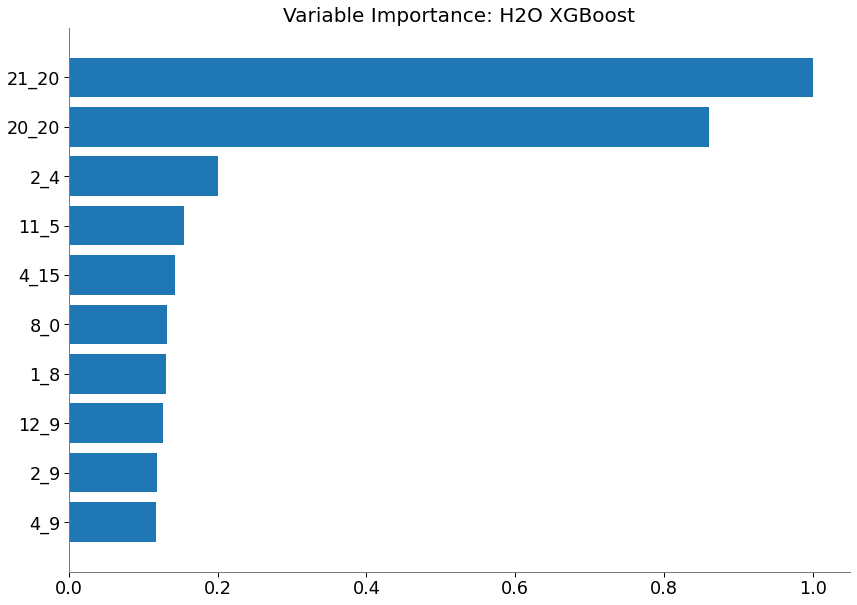

<Figure size 432x288 with 0 Axes>

In [64]:
best_model.varimp_plot()

In [63]:
# Retrieve the stored cross-validation (cv) holdout predictions
cv_hold_predictions = best_model.predict(df_test).as_data_frame()
cv_hold_predictions

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,predict
0,0.999768
1,0.999955
2,0.999960
3,0.999959
4,0.999980
...,...
5718,0.000007
5719,0.000007
5720,0.000008
5721,0.000007


In [64]:
if train: 
    # Make cv_pred to a dataframe
    as_data_frame_CV_predictions = best_model.cross_validation_holdout_predictions()
    as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
    as_data_frame_CV_predictions= as_data_frame_CV_predictions.as_data_frame()
    as_data_frame_CV_predictions

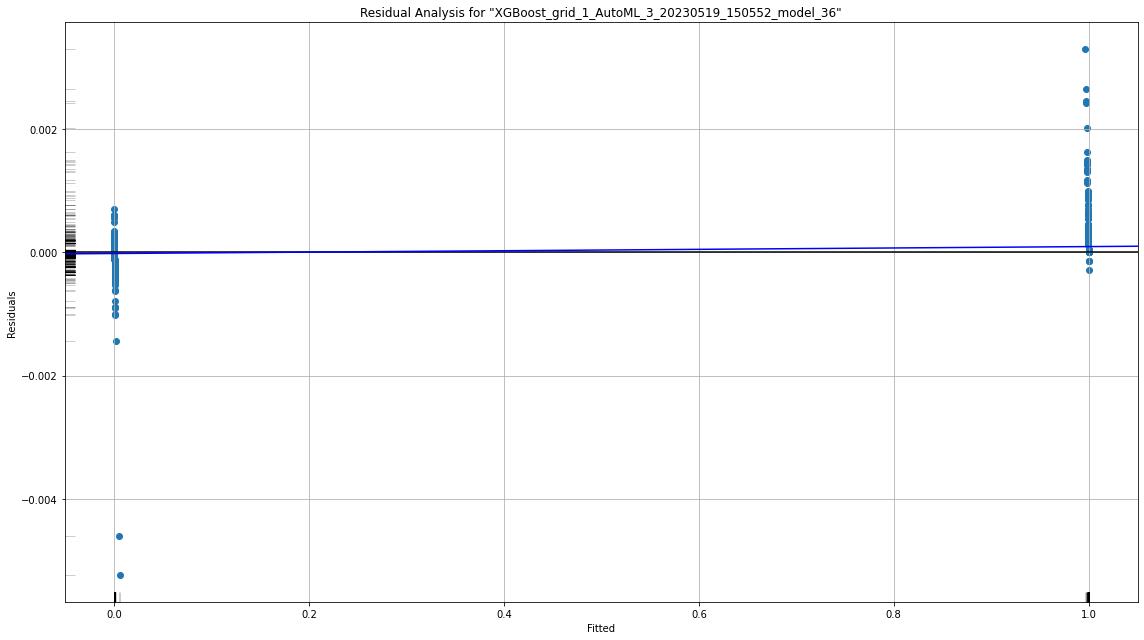

In [65]:
best_model.residual_analysis_plot(df_test)

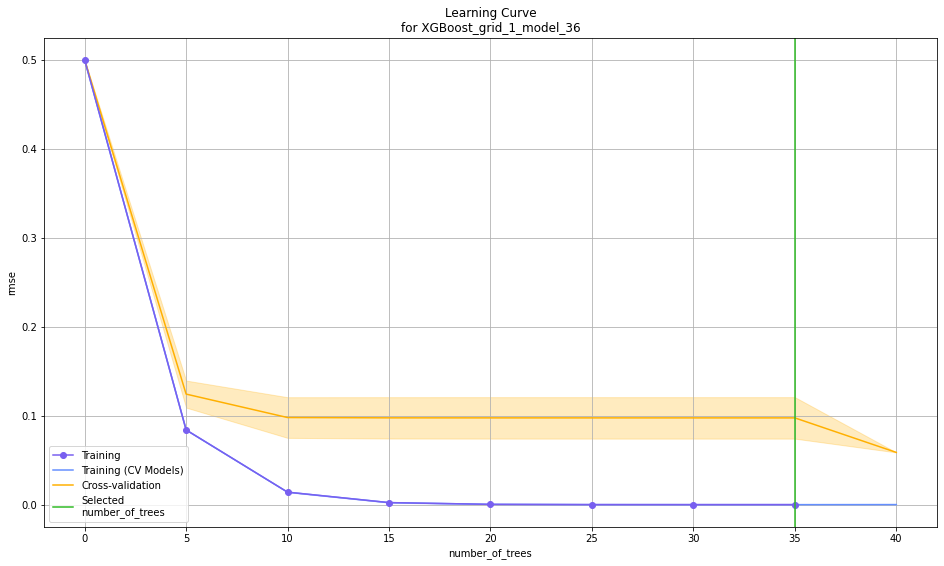

In [66]:
learning_curve_plot = best_model.learning_curve_plot()

In [67]:
best_model.cross_validation_metrics_summary()

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
mae,0.0109807,0.0043731,0.0055619,0.0114869,0.0174057,0.0076597,0.0184185,0.0060701,0.0087713,0.0100844,0.0132269,0.0111213
mean_residual_deviance,0.0100750,0.0047795,0.0042544,0.0105603,0.0169998,0.0071988,0.0177287,0.0034615,0.0076705,0.0097206,0.0126985,0.0104574
mse,0.0100750,0.0047795,0.0042544,0.0105603,0.0169998,0.0071988,0.0177287,0.0034615,0.0076705,0.0097206,0.0126985,0.0104574
r2,0.9218726,0.0371280,0.9672719,0.9179972,0.8679926,0.9441797,0.8625304,0.9731592,0.9405224,0.9246252,0.9015344,0.9189125
residual_deviance,0.0100750,0.0047795,0.0042544,0.0105603,0.0169998,0.0071988,0.0177287,0.0034615,0.0076705,0.0097206,0.0126985,0.0104574
rmse,0.0976325,0.0245615,0.0652256,0.1027631,0.1303834,0.0848458,0.1331490,0.0588345,0.0875812,0.0985933,0.1126878,0.1022613
rmsle,0.0683413,0.0162744,0.0472058,0.0717365,0.0906822,0.0593476,0.0920848,0.0435627,0.0610399,0.0677833,0.0785791,0.0713918


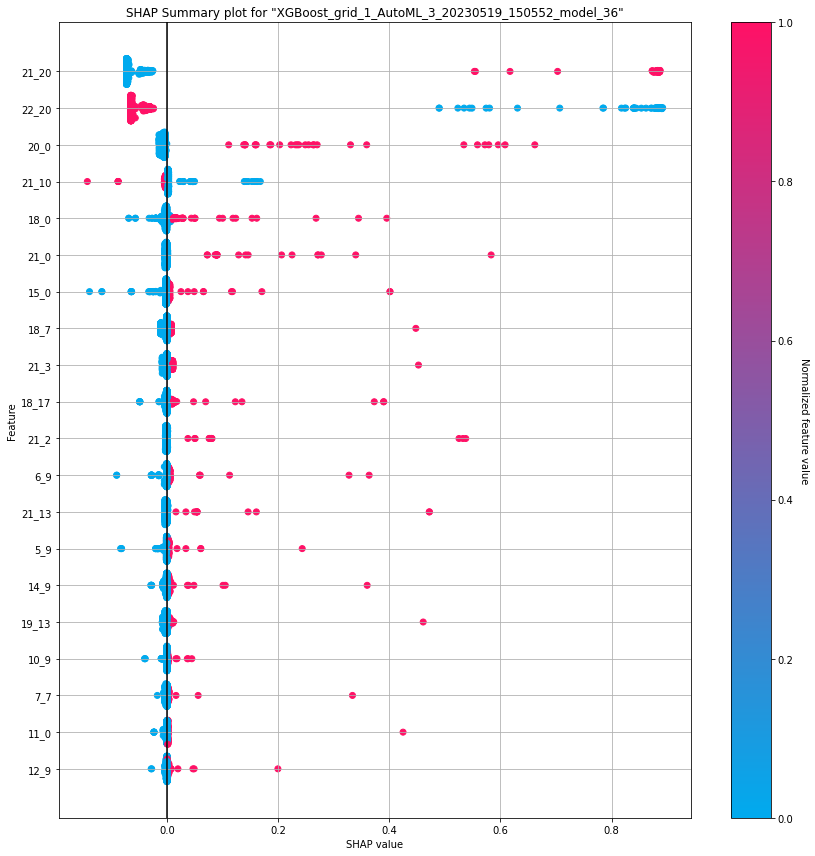

In [68]:
shap_plot = best_model.shap_summary_plot(df_test)


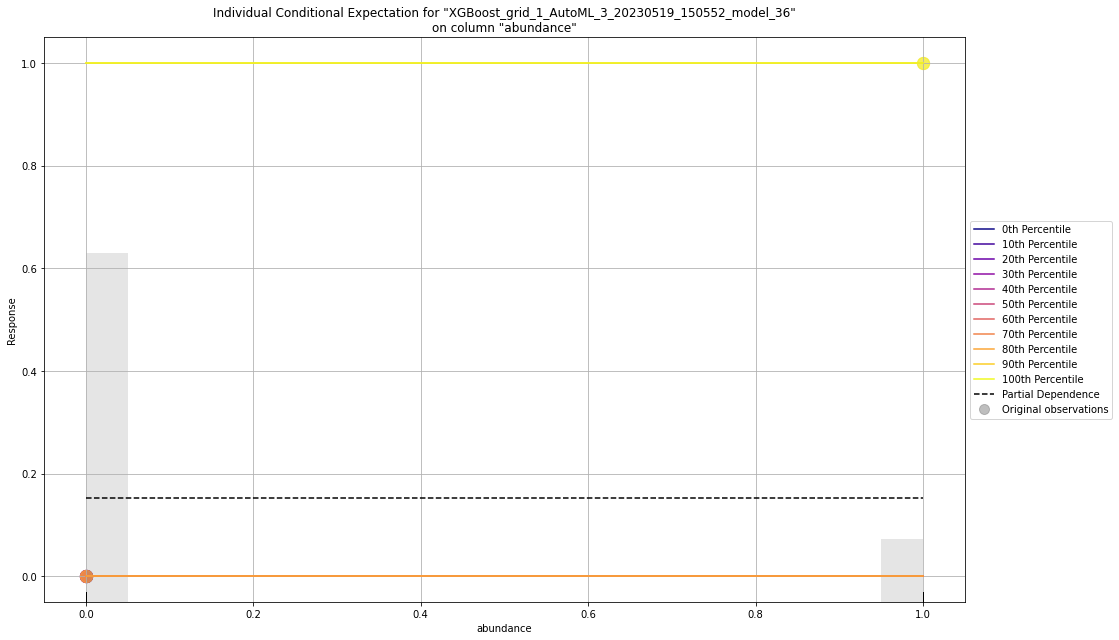

In [69]:
best_model.ice_plot(df_test, 'abundance')

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

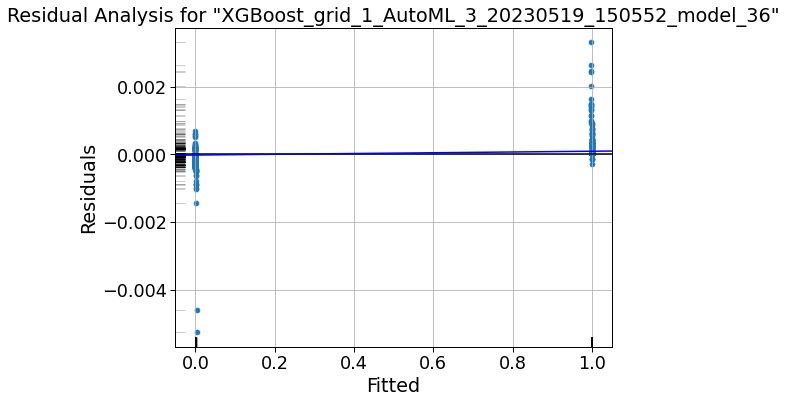

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

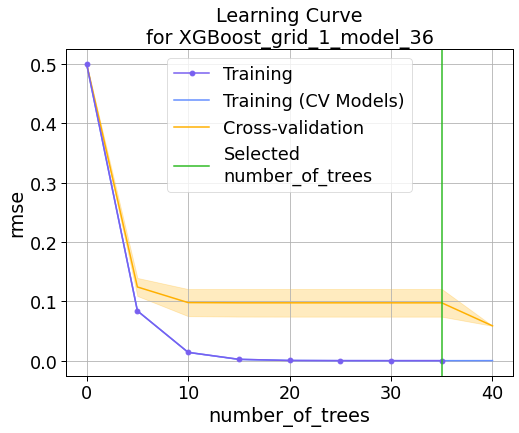

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

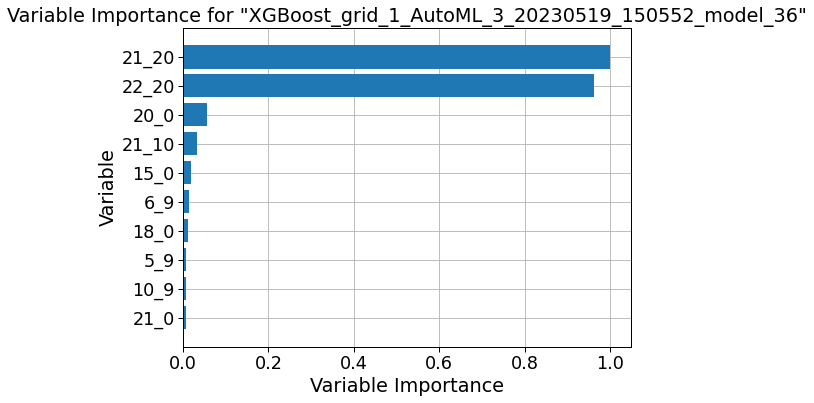

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

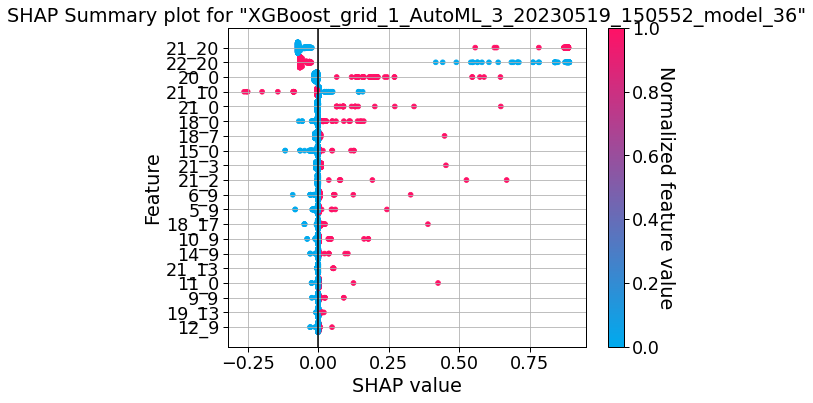

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

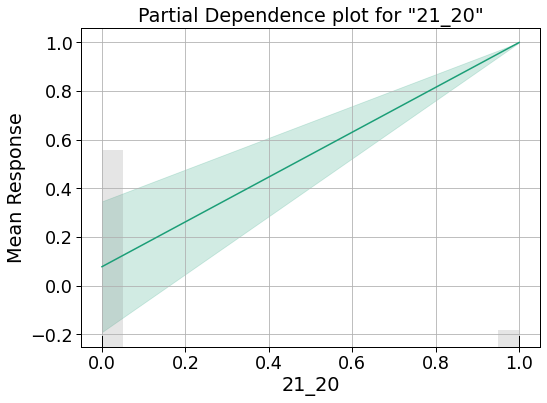

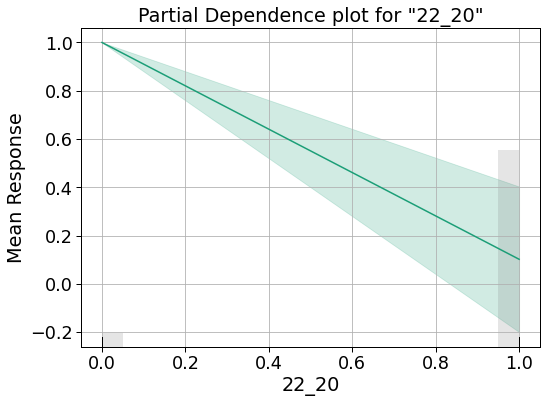

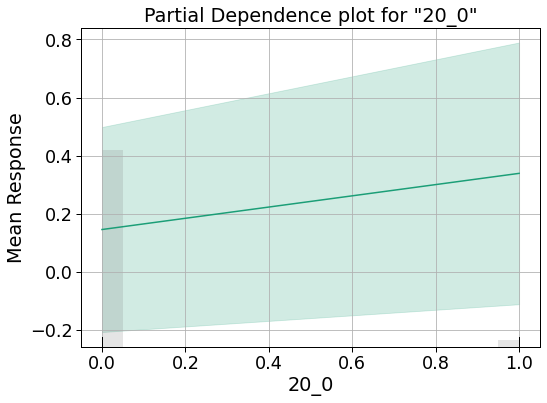

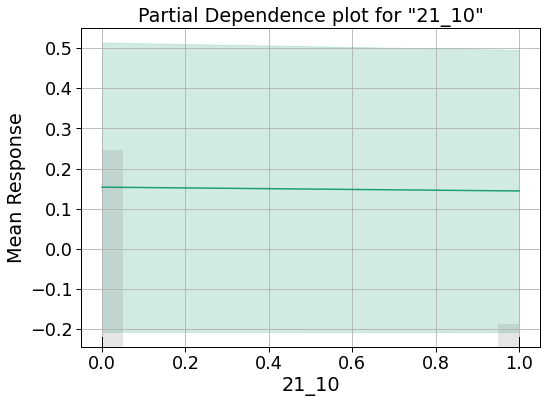

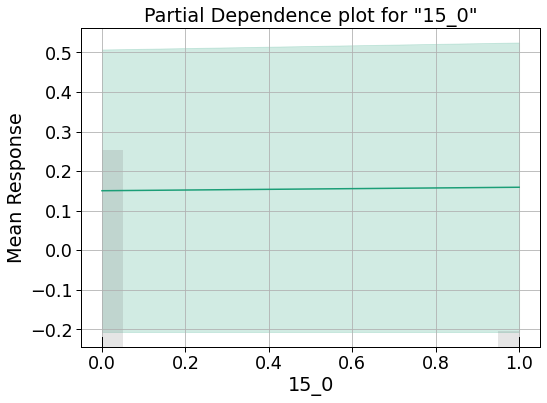

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

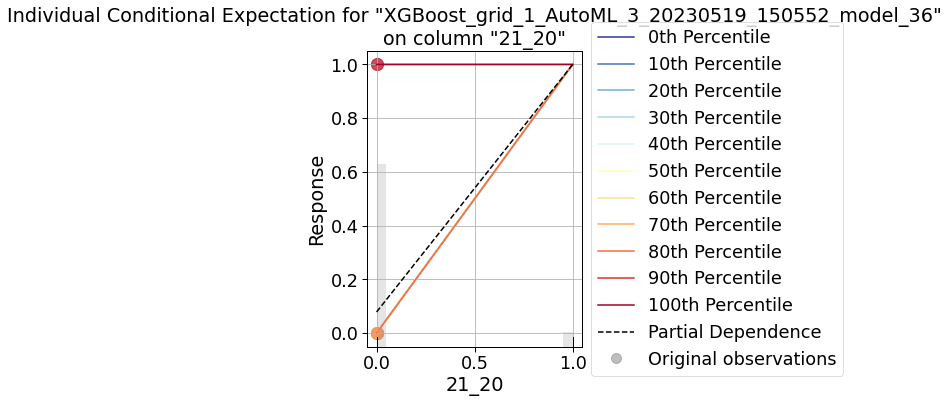

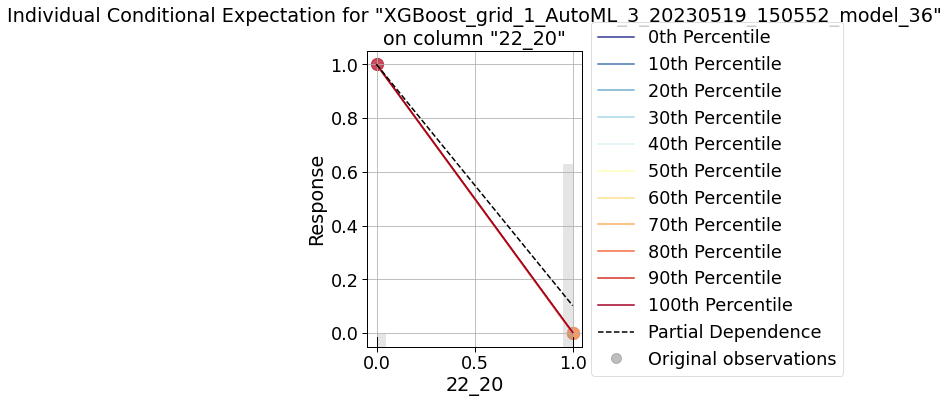

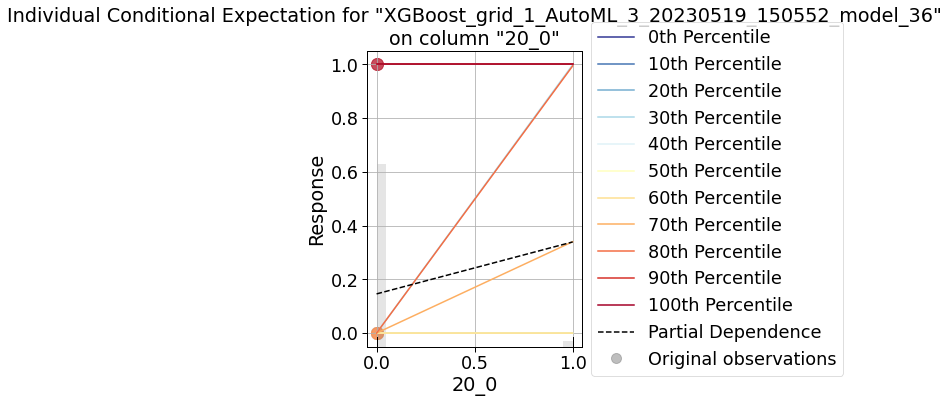

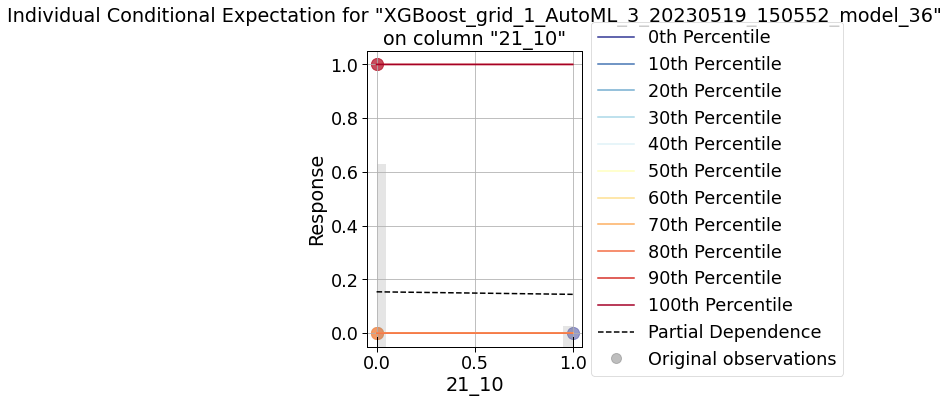

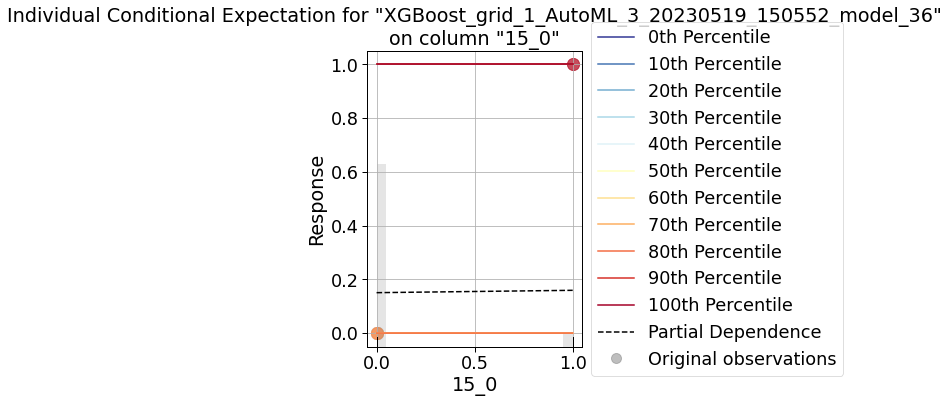

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [83]:
best_model.explain(frame = df_test, figsize = (8,6))


In [70]:
# Convert df_test into a dataframe
df_test_as_df = df_test.as_data_frame()
type(df_test_as_df)

pandas.core.frame.DataFrame

In [71]:
type(as_data_frame_CV_predictions)

pandas.core.frame.DataFrame

In [72]:
df_test_as_df

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,69_12,69_13,69_14,69_15,69_16,69_17,69_18,69_19,69_20,abundance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [73]:
# Merge the cv holdout predictions together with the df_test abundance
df_signalP_cv_holdout = pd.merge(df_test_as_df, as_data_frame_CV_predictions, left_index=True, right_index=True)

# Order the dataframe in the descending order of abundance values
df_signalP_cv_holdout = df_signalP_cv_holdout.sort_values(by= 'abundance', ascending = False)

# Rename the predict column
#df_signalP_cv_holdout = df_signalP_cv_holdout.rename(columns={'binary_classification': 'cv_hold_predictions'})

# Reset the indexing of the dataframe
df_signalP_cv_holdout = df_signalP_cv_holdout.reset_index()
df_signalP_cv_holdout


,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,69_13,69_14,69_15,69_16,69_17,69_18,69_19,69_20,abundance,cv_holdout_predictions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.999717
1,585,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.999972
2,574,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.999960
3,575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.999964
4,576,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.999511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,2486,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.000022
5719,2485,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,-0.000009
5720,2484,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.000012
5721,2483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.000010


In [84]:
df_signalP_cv_holdout.to_clipboard()

In [74]:
# Generate percentage ranking of the abundance and cv_predictions 
df_signalP_cv_holdout['abundance_ranked_pct'] = df_signalP_cv_holdout['abundance'].rank(pct=True)
df_signalP_cv_holdout['cv_ranked_pct'] = df_signalP_cv_holdout['cv_holdout_predictions'].rank(pct=True)
df_signalP_cv_holdout

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,69_15,69_16,69_17,69_18,69_19,69_20,abundance,cv_holdout_predictions,abundance_ranked_pct,cv_ranked_pct
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.999717,0.923991,0.858815
1,585,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.999972,0.923991,0.987681
2,574,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.999960,0.923991,0.950376
3,575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.999964,0.923991,0.964092
4,576,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.999511,0.923991,0.856194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,2486,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.000022,0.423991,0.688887
5719,2485,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,-0.000009,0.423991,0.059060
5720,2484,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.000012,0.423991,0.574699
5721,2483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.000010,0.423991,0.405731


In [90]:
holdout_predictions = df_signalP_cv_holdout['cv_holdout_predictions'].to_list()

binary_holdout_predictions = []
for pred in holdout_predictions: 
    if pred < 0.01:
        binary_holdout_predictions.append(0)
    else: 
        binary_holdout_predictions.append(1)


In [92]:
df_signalP_cv_holdout['binary_cv_predictions'] = binary_holdout_predictions
df_signalP_cv_holdout

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,69_17,69_18,69_19,69_20,abundance,cv_holdout_predictions,abundance_ranked_pct,cv_ranked_pct,color,binary_cv_predictions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.999717,0.923991,0.858815,black,1
1,585,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.999972,0.923991,0.987681,black,1
2,574,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.999960,0.923991,0.950376,black,1
3,575,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.999964,0.923991,0.964092,black,1
4,576,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.999511,0.923991,0.856194,black,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,2486,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.000022,0.423991,0.688887,black,0
5719,2485,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.000009,0.423991,0.059060,black,0
5720,2484,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.000012,0.423991,0.574699,black,0
5721,2483,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.000010,0.423991,0.405731,black,0


In [93]:
from sklearn.metrics import confusion_matrix
y_true = df_signalP_cv_holdout['abundance'].to_list()
y_pred = df_signalP_cv_holdout['binary_cv_predictions'].to_list()
confusion_matrix(y_true, y_pred)

array([[4802,   50],
       [  28,  843]])

In [94]:
from sklearn.metrics import precision_score

precision_score(y_true, y_pred, average='macro')

0.9691059285586769

In [75]:
from teemi.learn.plotting import correlation_plot

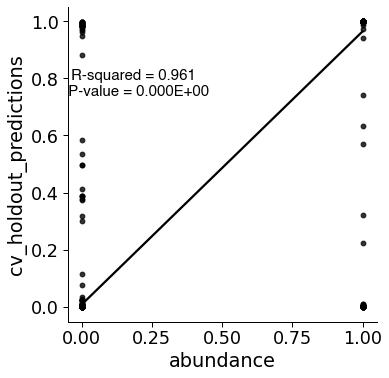

In [76]:
correlation_plot(df_signalP_cv_holdout, 
                    x='abundance',
                    y = "cv_holdout_predictions", save_pdf = False , 
                 path ='G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_rank',
                 title = '',
                 size_height= 5, 
                 size_length = 5)

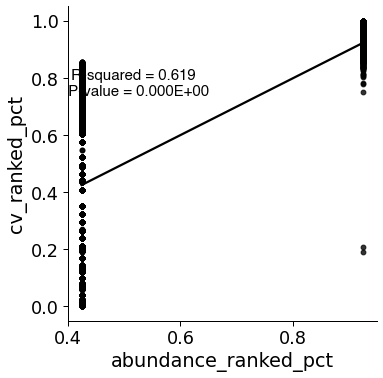

In [77]:
correlation_plot(df_signalP_cv_holdout, 
                    x='abundance_ranked_pct',
                    y = "cv_ranked_pct", save_pdf = False , 
                 path ='G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_rank',
                 title = '',
                 size_height= 5, 
                 size_length = 5)

In [78]:
# Save the dataframe
df_signalP_cv_holdout.to_csv('../data/04_ML_models/cv_holdout_pred/XGBoost_grid_1_AutoML_1_20230502_111614_model_131.csv')

## 5 Visualization of AutoML model

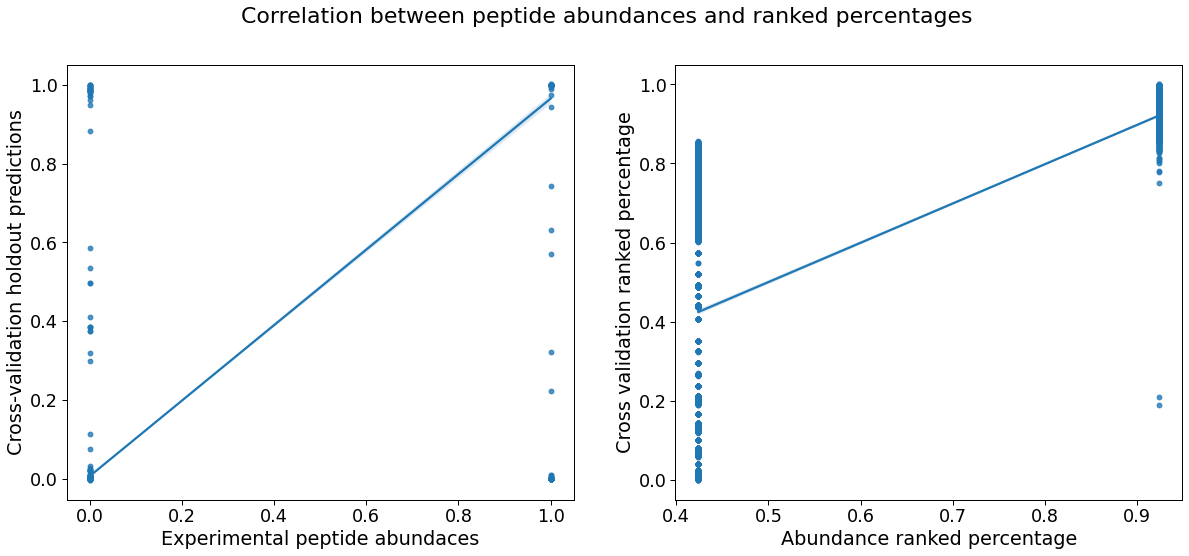

In [79]:
# Set the font size before creating any plot elements
plt.rc('font', size=20)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# Left subplot
sns.regplot(x='abundance',y='cv_holdout_predictions', data=df_signalP_cv_holdout, ax=axs[0])
axs[0].set_xlabel('Experimental peptide abundaces')
axs[0].set_ylabel('Cross-validation holdout predictions')

# Right subplot
sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout, ax=axs[1])
axs[1].set_xlabel('Abundance ranked percentage')
axs[1].set_ylabel('Cross validation ranked percentage')

plt.show()

In [53]:
# Drop rows where NaN values of the peptide abundance was set to 0 to reduce noise (i.e. create a dataframe without (wo) NaN/zero values)
df_signalP_cv_holdout_wo_NaNs = df_signalP_cv_holdout[df_signalP_cv_holdout['abundance'] != 0]
df_signalP_cv_holdout_wo_NaNs

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,21_16,21_17,21_18,21_19,21_20,abundance,cv_holdout_predictions,abundance_ranked_pct,cv_ranked_pct,color
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.499146,0.984339,0.983533,black
1,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.971118,0.984339,0.999642,black
2,113,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.082119,0.984339,0.916413,black
3,114,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.062821,0.984339,0.909612,black
4,115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.013875,0.984339,0.884016,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.225016,0.984339,0.946304,black
172,61,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.016709,0.984339,0.886701,black
173,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.067752,0.984339,1.000000,black
174,47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.297092,0.984339,0.958833,black


In [54]:
# # Set the font size before creating any plot elements
# plt.rc('font', size=20)

# # Create a figure with 2 subplots side by side
# fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
# fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# # Left subplot
# sns.regplot(x='abundance',y='cv_hold_predictions', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[0])
# axs[0].set_xlabel('Experimental peptide abundaces')
# axs[0].set_ylabel('Cross-validation holdout predictions')

# # Right subplot
# sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[1])
# axs[1].set_xlabel('Abundance ranked percentage')
# axs[1].set_ylabel('Cross validation ranked percentage')

# plt.show()

In [55]:
# Save the resulting dataframe
#df_signalP_cv_holdout_wo_NaNs.to_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/06.3_Cv_holdout_predictions/Second_round/DeepLearning_grid_1_AutoML_1_20230501_95004_model_3.csv', index=False)

In [56]:
h2o.shutdown()

H2O session _sid_aa38 closed.


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_14169/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
